# Pixeles

## Librerias

In [1]:
from sklearn.preprocessing import MinMaxScaler
from typing import List
from matplotlib import colors
from skimage import exposure
from tqdm.notebook import tqdm

import rasterio as rio
import rasterio.plot as rio_plot
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import json

# Semilla pseudoaleatoria
np.random.seed(24)

# Tamaño de las figuras
plt.rcParams["figure.figsize"] = (20,10)

# Ruta base de la carpeta de datos
DATA_BASE = "/home/ggonzr_cloud/deeplearn/data"

## Exploración

En este apartado vamos a explorar algunas imagenes del conjunto de datos, los archivos que contiene la etiqueta de la imagen y la máscara.

### Carga de imágenes

A continuación vamos a buscar las rutas de acceso a las imagenes. Dado a que el conjunto de etiquetas es más pequeño que las imagenes, vamos a emplear un conjunto reducido tal que tengamos etiquetas para todas la imagenes a emplear

In [2]:
# Directorios de las etiquetas y la imagenes
LABEL_DIR = f"{DATA_BASE}/ref_landcovernet_v1_labels"
IMAGE_DIR = f"{DATA_BASE}/ref_landcovernet_v1_source"

In [3]:
# Listar los subdirectorios de cada carpeta: Etiquetas
label_dirs = glob.glob(f"{LABEL_DIR}/*")
print(f"Número de etiquetas disponibles: {len(label_dirs)}")

Número de etiquetas disponibles: 1982


In [4]:
# Listar los subdirectorios de cada carpeta: Etiquetas
image_dirs = glob.glob(f"{IMAGE_DIR}/*")
print(f"Número de etiquetas disponibles: {len(image_dirs)}")

Número de etiquetas disponibles: 82430


In [5]:
label_dirs[0]

'/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_36PZC_07'

In [6]:
image_dirs[0]

'/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_source/ref_landcovernet_v1_source_33LYE_11_20180818'

# Conteo de pixeles por las etiquetas

In [7]:
def create_response() -> dict:
    labels_tag = list(range(1,8))
    zeros_list = np.zeros(len(labels_tag))
    zeros_list = zeros_list.tolist()
    cont_dict = dict(zip(labels_tag, zeros_list))
    cont_dict["chip_id"] = ""
    cont_dict["label_folder"] = ""
    return cont_dict

In [8]:
def pixel_count(path_label: str) -> dict:
    folder_name = path_label.split("/")[-1]
    name_split = folder_name.split("_")
    chip_name = f"{name_split[-2]}_{name_split[-1]}"
    
    label_shape = glob.glob(f"{path_label}/label*")[0]    
    
    # Cargar la mascara
    label_mask = None
    with rio.open(label_shape, 'r') as rf:
        label_mask = rf.read(1)
    
    # Realizar el conteo
    class_tag, pix_count = np.unique(label_mask, return_counts=True)
    class_tag = class_tag.tolist()
    pix_count = pix_count.tolist()
    
    # Instanciar diccionario de retorno
    rsp = create_response()
    
    # Retorno
    pix_dict = dict(zip(class_tag, pix_count))
    pix_dict["chip_id"] = chip_name
    pix_dict["label_folder"] = path_label
    
    return {**rsp, **pix_dict}

In [9]:
# Procesamiento
process_result = []

In [10]:
for lf in tqdm(label_dirs):
    try:
        pxd = pixel_count(lf)
        process_result.append(pxd)    
    except:
        continue

  0%|          | 0/1982 [00:00<?, ?it/s]

In [11]:
# Guardar datos
with open(f"{DATA_BASE}/pixel_report.json", "w", encoding="utf-8") as v_f:
    json.dump(process_result, v_f, ensure_ascii=False, indent=4)

NameError: name 'ex_mask_rio' is not defined

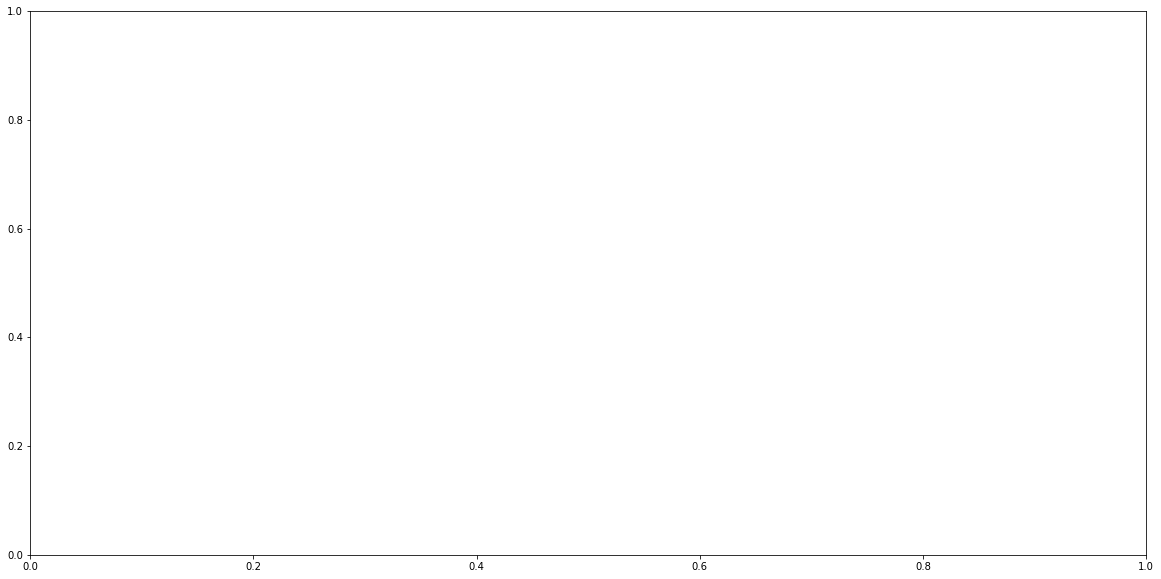

In [12]:
fig, ax = plt.subplots()
img = ax.imshow(ex_mask_rio.read(1), cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ax=ax)
cbar.set_ticks(boundaries)
cbar.set_ticklabels(meaning)
cbar.config_axis
plt.show()

In [ ]:
ex_image_red_rio = rio.open(ex_img_red)
ex_image_green_rio = rio.open(ex_img_green)
ex_image_blue_rio = rio.open(ex_img_blue)

In [ ]:
print(f"Metadatos{ex_image_red_rio.meta}")

Como podemos observar, la imagen posee 10 bandas. A continuación, vamos a visualizar la imagen en combinación de color verdadero

In [ ]:
ex_image_red_rio_data = ex_image_red_rio.read(1)
ex_image_green_rio_data = ex_image_green_rio.read(1)
ex_image_green_rio_data = ex_image_blue_rio.read(1)

Escalar la imagen

In [ ]:
# Combinación RGB
ex_image_rgb = np.array([
    ex_image_red_rio_data,
    ex_image_green_rio_data,
    ex_image_green_rio_data
])

# Reescalar los datos de las bandas
mms = MinMaxScaler(feature_range=(0, 255))
ex_c = ex_image_rgb.copy()
p2, p98 = np.percentile(ex_c, (2,98))

image = exposure.rescale_intensity(ex_c, in_range=(p2, p98)) / 100000

#for band in range(ex_c.shape[0]):
#    ex_c[band] = mms.fit_transform(ex_c[band])

# Mostrar
rio_plot.show(image, transform=ex_image_red_rio.transform)

In [ ]:
ex_mask = glob.glob(f"{ex_img_folder}/SCL.*")[0]
ex_mask_rio = rio.open(ex_mask)

In [ ]:
print(f"Metadatos{ex_mask_rio.meta}")

In [ ]:
# Primera capa con las etiquetas
ex_labels_mask = ex_mask_rio.read(1)

In [ ]:
ex_labels_mask

In [ ]:
# Crear un colormap personalizado para cada una de las etiquetas
# según el documento
cmap = colors.ListedColormap([
    "#0000ff",
    "#888888",
    "#d1a46d",
    "#f5f5ff",
    "#d64c2b",
    "#186818",
    "#00ff00"
])
meaning = [
    "Agua",
    "Suelo desnudo artificial",
    "Suelo desnudo natural",
    "Nieve",
    "Bosque (Woody soil)",
    "Terreno cultivado",
    "Vegetación (semi) natural"
]
boundaries = list(range(1,8))
norm = colors.BoundaryNorm(boundaries, cmap.N)

In [ ]:
fig, ax = plt.subplots()
img = ax.imshow(ex_mask_rio.read(1), cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ax=ax)
cbar.set_ticks(boundaries)
cbar.set_ticklabels(meaning)
cbar.config_axis
plt.show()

In [ ]:
ex_img_cloudmask = glob.glob(f"{ex_img_folder}/CLD.*")[0]
ex_cloud_mask = rio.open(ex_img_cloudmask)

In [ ]:
print(f"Metadatos de la máscara de nubes: {ex_cloud_mask.meta}")

In [ ]:
cloud_layer = ex_cloud_mask.read(1)

In [ ]:
np.mean(cloud_layer)

In [ ]:
fig, ax = plt.subplots()
img = ax.imshow(ex_cloud_mask.read(1), cmap=plt.get_cmap("gist_yarg"))
fig.colorbar(img, ax=ax)